In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

####################################################
# Load the data
df = pd.read_csv("n/full_data_flightdelay.csv.xz", compression='xz')
#print(df.head())

# take a random sample of 1000 rows
df = df.sample(n=10000, random_state=42) # use random_state for reproducibility

ontime = df[df['DEP_DEL15'] == 0]
delayed = df[df['DEP_DEL15'] == 1]

In [40]:
# DATA CLEANING
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK']
df = clean_labels_encoder(list_of_labels, df)

# Fill the missing values
df.fillna(df.mean(), inplace=True)

# Drop target variable
df_clustering = df.drop(columns=['DEP_DEL15']) 

# Normalize/Standarize the data
standard_scaler = StandardScaler()
minmax_scalar = MinMaxScaler()
df_standardize = standard_scaler.fit_transform(df_clustering)
df_normalize = minmax_scalar.fit_transform(df_clustering)

# Convert the scaled data back to a DataFrame
df_standardize = pd.DataFrame(df_standardize, columns=df_clustering.columns)
df_normalize = pd.DataFrame(df_normalize, columns=df_clustering.columns )

In [42]:
# Clustering helper functions
def visualize_cluster(x, y, clustering, filename="filename.png"):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x, y, c=clustering, cmap='coolwarm', s=5)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(filename)
    plt.show()
    plt.close()
    return 0

def reduce_dimensions(data, method="pca", n_components=2):
    if method == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
    elif method == "tsne":
        reducer = TSNE(n_components=n_components, random_state=42)
    else:
        raise ValueError("Unsupported dimensionality reduction method!")
    return reducer.fit_transform(data)

In [43]:
# K-Means
# To find the best K - Fit K-Means for different K values
sil_scores = []
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_normalize)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_normalize, kmeans.labels_))


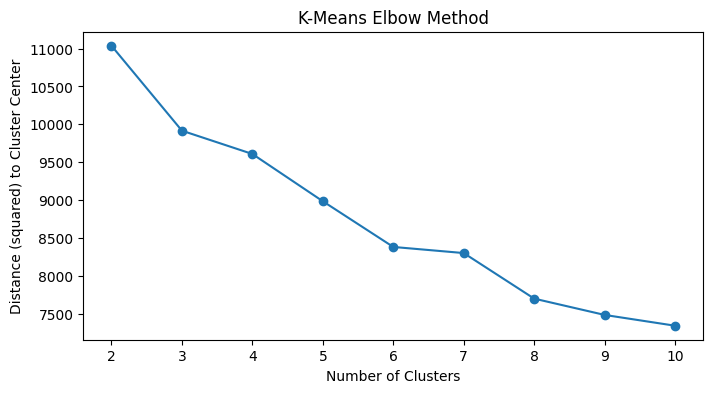

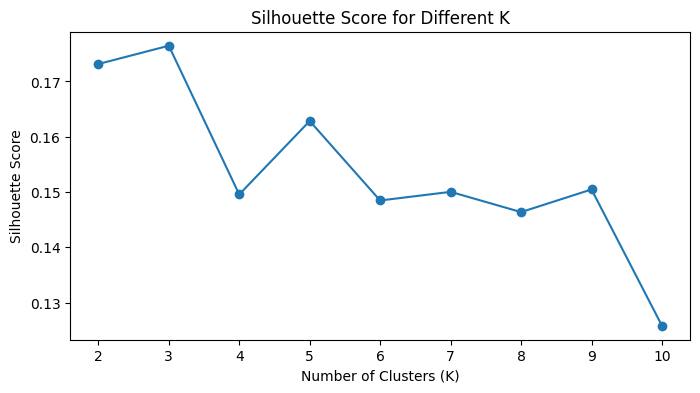

In [44]:
# Plot inertia values
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o', label='Inertia')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance (squared) to Cluster Center")
plt.title("K-Means Elbow Method")
plt.show()

# Plot Silhouette Score values 
plt.figure(figsize=(8, 4))
plt.plot(k_range, sil_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score for Different K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.show()

In [56]:
# The elbow method suggests the "elbow" point for this data appears at k=3, because the largest decrease occurs between k=2 and k=3
# The silhouette scores also suggest that k=3 as it has the highest score

# Dimensionality Reduction (use PCA or t-SNE)
reduced_data_pca = reduce_dimensions(df_normalize, method="pca")  # 2D PCA
reduced_data_tsne = reduce_dimensions(df_normalize, method="tsne")  # 2D t-SNE

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_normalize)
df_normalize['cluster'] = kmeans.fit_predict(df_normalize)
print(df_normalize.cluster.value_counts())


cluster
1    4703
0    3751
2    1546
Name: count, dtype: int64


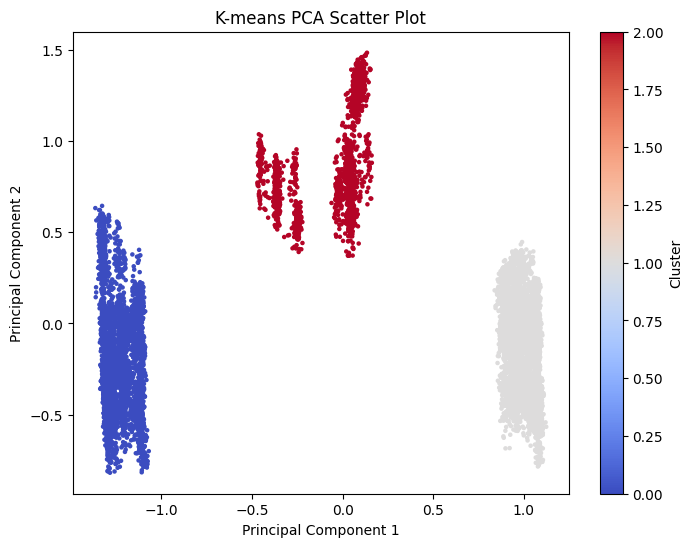

0

In [57]:
visualize_cluster(reduced_data_pca[:, 0], reduced_data_pca[:, 1], kmeans_labels, "K-means PCA Scatter Plot")

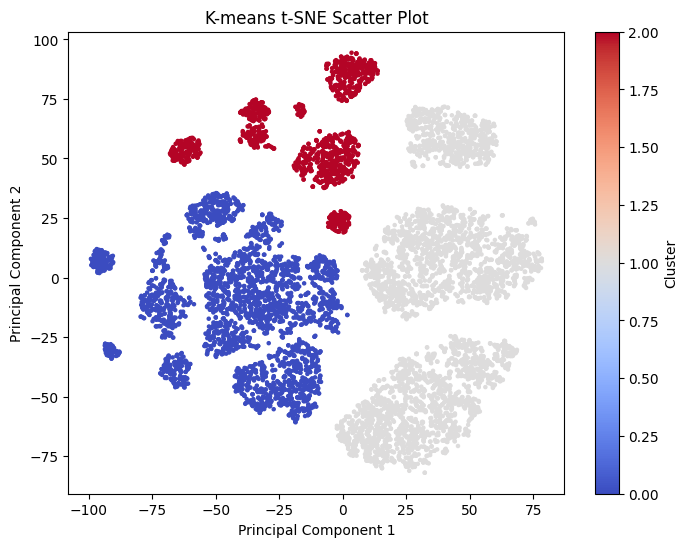

0

In [58]:
visualize_cluster(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], kmeans_labels, "K-means t-SNE Scatter Plot")

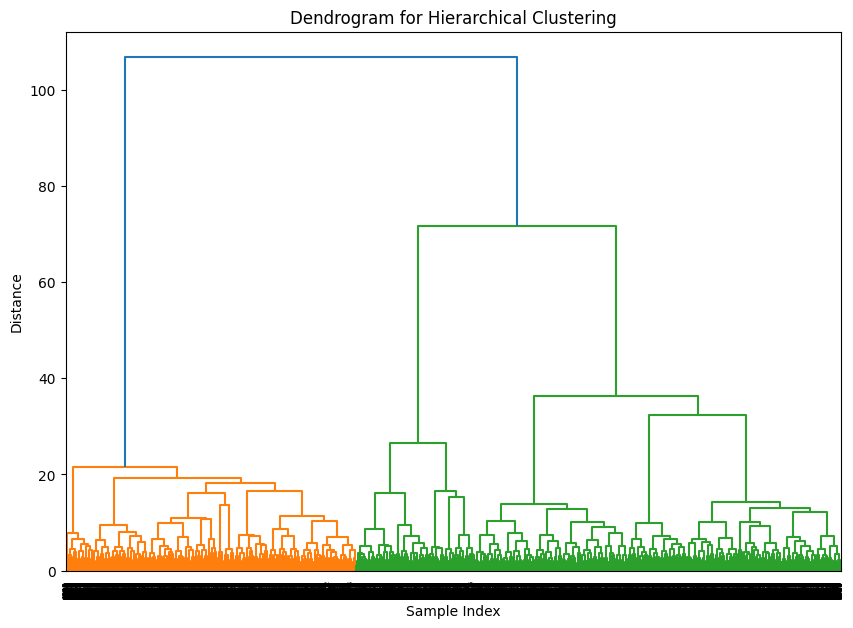

In [59]:
# Hierarchical Clustering (Agglomerative Clustering)

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix
Z = linkage(df_normalize, method='ward')  # 'ward' minimizes the variance of clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

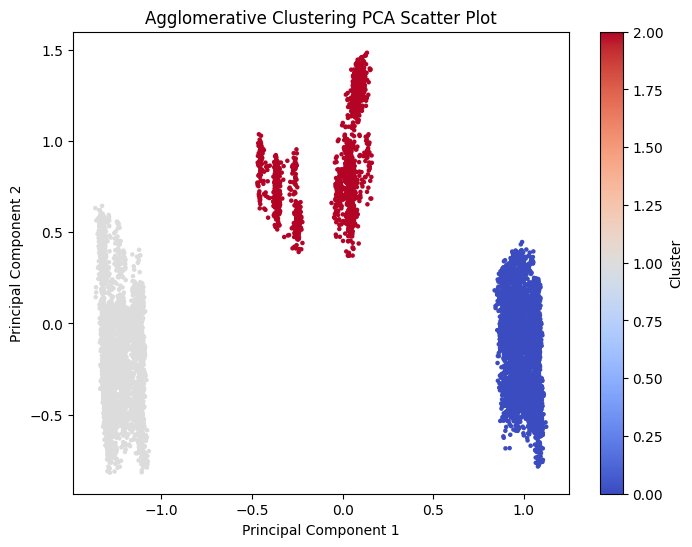

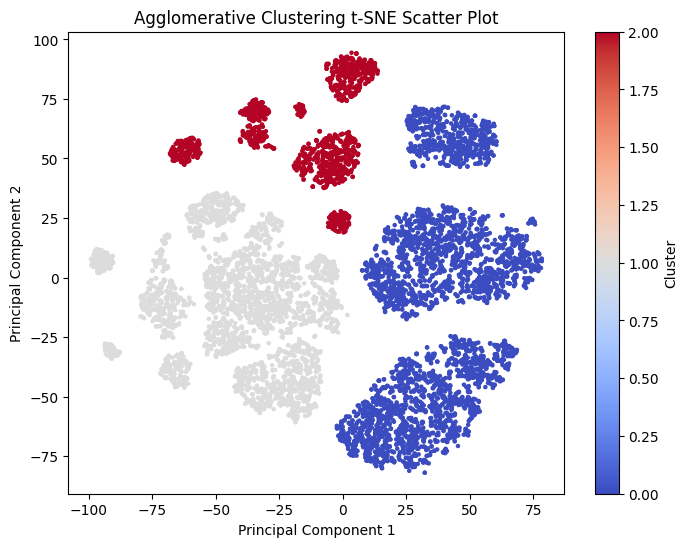

0

In [61]:
# The visualization of the dendrogram suggest that k=3, because there are three large vertical gaps in the upper levels of the tree
# the blue line at the top shows the largest merges, and splits off into three main groups 
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_labels = agg_clustering.fit_predict(df_normalize)

# Visualize Hierarchical Clustering Results
visualize_cluster(reduced_data_pca[:, 0], reduced_data_pca[:, 1], agg_labels, "Agglomerative Clustering PCA Scatter Plot")
visualize_cluster(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], agg_labels, "Agglomerative Clustering t-SNE Scatter Plot")

In [71]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Evaluate Clustering Performance
# Store the clustering performance metrics
kmeans_metrics = []
agg_metrics = []

kmeans_metrics.append({
        "K": 3,
        "Algorithm": "K-Means",
        "Silhouette Score": silhouette_score(df_normalize, kmeans_labels),
        "Calinski-Harabasz Index": calinski_harabasz_score(df_normalize, kmeans_labels),
        "Davies-Bouldin Index": davies_bouldin_score(df_normalize, kmeans_labels)
    })

agg_metrics.append({
    "K": 3, 
    "Algorithm": "Agglomerative",
    "Silhouette Score": silhouette_score(df_normalize, agg_labels),
    "Calinski-Harabasz Index": calinski_harabasz_score(df_normalize, agg_labels),
    "Davies-Bouldin Index": davies_bouldin_score(df_normalize, agg_labels)
})

# Convert the metrics lists to DataFrames
kmeans_df = pd.DataFrame(kmeans_metrics)
agg_df = pd.DataFrame(agg_metrics)

# Combine both DataFrames
clustering_metrics_df = pd.concat([kmeans_df, agg_df], ignore_index=True)
clustering_metrics_df




,K,Algorithm,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,3,K-Means,0.301736,4160.713884,1.372599
1,3,Agglomerative,0.301736,4160.713884,1.372599


In [66]:
# Outlier Detection

from scipy.stats import zscore
# To obtain an approximation of the fraction of anomalous data points in the dataset
# the estimate for contamination is calculated by dividing the total number of outliers by the total number of samples

z_scores = np.abs(zscore(df_normalize))
outliers_count = (z_scores > 3).max(axis=1).sum()
contamination_estimate = outliers_count / df_normalize.shape[0]

print(f"Estimated contamination: {contamination_estimate:.2f}")


Estimated contamination: 0.13


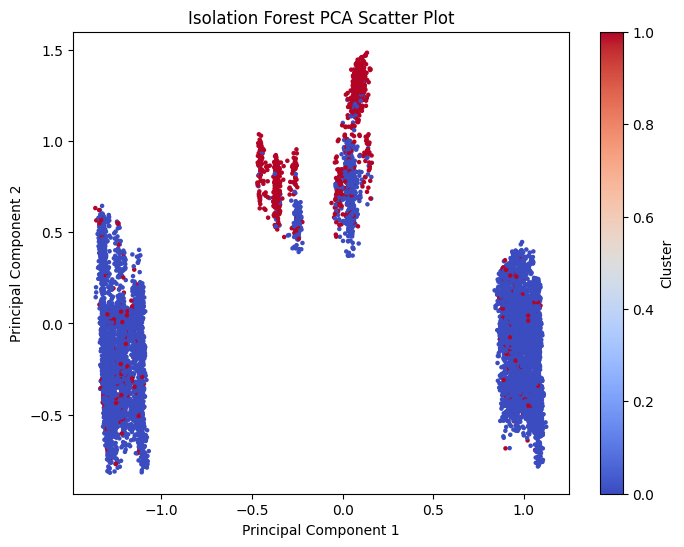

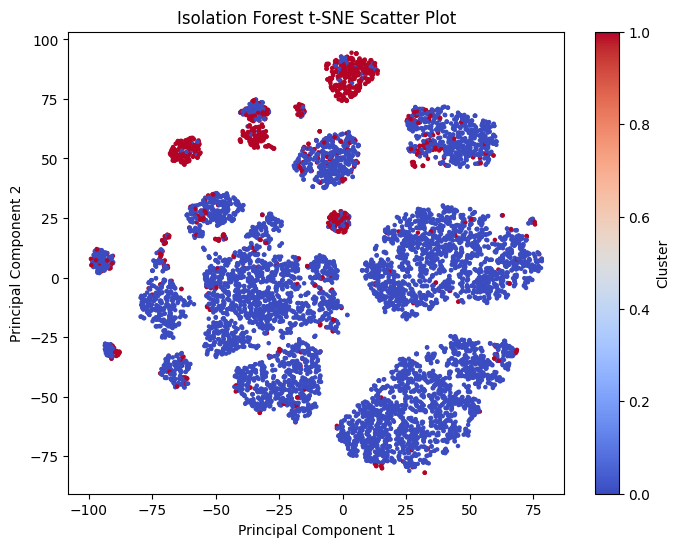

0

In [69]:
from sklearn.ensemble import IsolationForest

# Isolation Forest
iso_forest = IsolationForest(contamination=0.13, random_state=42)
outliers_iso = iso_forest.fit_predict(df_normalize)

# print(f"Outliers detected: {(outliers_iso == -1).sum()} / {len(outliers_iso)}")

# Mark outliers (1 = inlier, -1 = outlier)
outliers_iso = (outliers_iso == -1)

# Filter out outliers 
df_no_outliers_iso = df_normalize[~outliers_iso]  # keep only the inliers

# Use the visualize cluster helper function to visualize outliers in a scatterplot
visualize_cluster(reduced_data_pca[:, 0], reduced_data_pca[:, 1], outliers_iso, "Isolation Forest PCA Scatter Plot")
visualize_cluster(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], outliers_iso, "Isolation Forest t-SNE Scatter Plot")

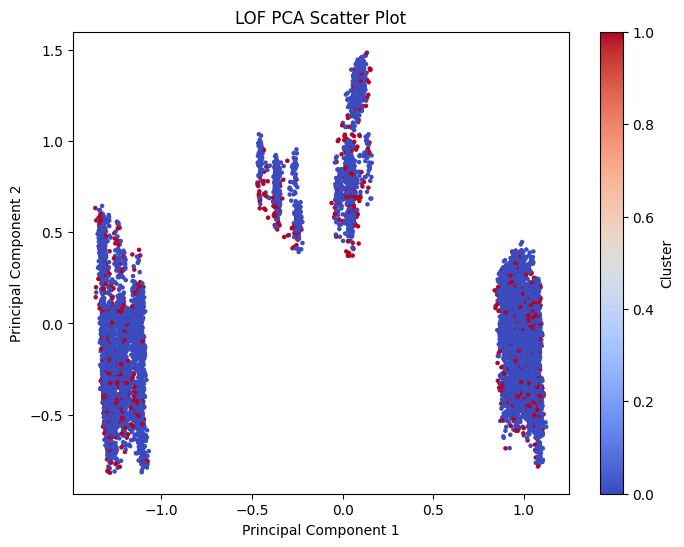

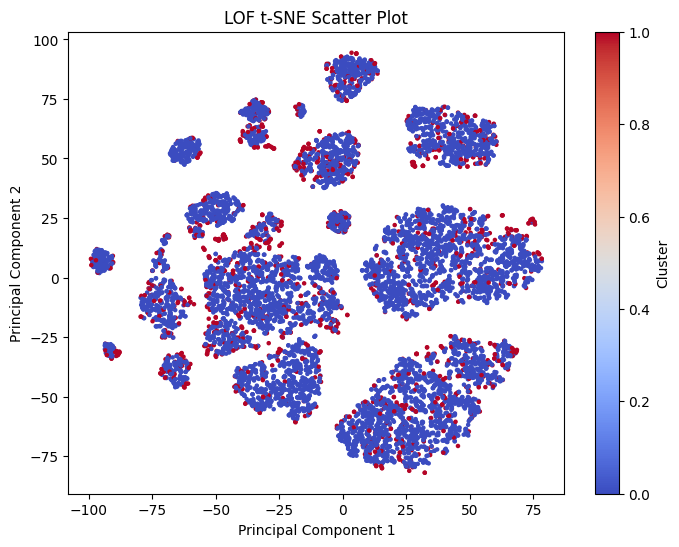

0

In [70]:
from sklearn.neighbors import LocalOutlierFactor

# Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.13)
outliers_lof = lof.fit_predict(df_normalize)

# print(f"Outliers detected: {(outliers_lof == -1).sum()} / {len(outliers_lof)}")

# Mark outliers (1 = inlier, -1 = outlier)
outliers_lof = (outliers_lof == -1)

df_no_outliers_lof = df_normalize[~outliers_iso]

visualize_cluster(reduced_data_pca[:, 0], reduced_data_pca[:, 1], outliers_lof, "LOF PCA Scatter Plot")
visualize_cluster(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], outliers_lof, "LOF t-SNE Scatter Plot")
